# Michelin Rated Restaurants in France - Analysis

In [1]:
# Module import
import pandas as pd
import geopandas as gpd

In [2]:
# Function import
from functions import dataframe_info, top_restaurants_by_department, top_restaurants_by_region, plot_choropleth, plot_multi_choropleth

Importing the processed data

In [3]:
# All restaurants
all_france = pd.read_csv("../../data/France/all_restaurants.csv")

In [4]:
# We define Paris, 75
paris = all_france[all_france['city'] == 'Paris']

# Everything but Paris
rest_of_france = all_france[all_france['city'] != 'Paris']

----
&nbsp;
#### Michelin Rated Restaurants Information

In [5]:
dataframe_info(all_france)

Unique Departments: 92
Unique Cities: 617
Shape: (1033, 15)


,name,address,city,department_num,department,region,country,price,price_num,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,"Plage de la Bouillabaisse, Saint-Tropez, 83990...",Saint-Tropez,83,Var,Provence-Alpes-Côte d'Azur,France,€€€€,4,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,"Hameau de Saint-Marcel, Saint-Martin-de-Belle...",Saint-Martin-de-Belleville,73,Savoie,Auvergne-Rhône-Alpes,France,€€€€,4,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,"5 rue du Coq-Héron, Paris, 75001, France",Paris,75,Paris,Île-de-France,France,€€€€,4,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395


In [6]:
dataframe_info(paris)

Unique Departments: 1
Unique Cities: 1
Shape: (159, 15)


,name,address,city,department_num,department,region,country,price,price_num,cuisine,url,award,stars,longitude,latitude
2,Kei,"5 rue du Coq-Héron, Paris, 75001, France",Paris,75,Paris,Île-de-France,France,€€€€,4,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
11,Le Pré Catelan,"Route de Suresnes - bois de Boulogne, Paris, 7...",Paris,75,Paris,Île-de-France,France,€€€€,4,"Modern Cuisine, Classic Cuisine",https://www.leprecatelan.com/,3 MICHELIN Stars,3.0,2.250718,48.863937
13,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré, ...",Paris,75,Paris,Île-de-France,France,€€€€,4,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 MICHELIN Stars,3.0,2.314625,48.871762


----
&nbsp;
## Analysis of Michelin Stars by department and region

### `top_restaurants_by_department` function

Imported below and defined in `functions.py`, this function analyses a dataset of restaurants and outputs the top $n$ departments with the highest count of restaurants with a specified Michelin star rating.

Usage:
```python
top_restaurants_by_department(data, star_rating, top_n, display_restaurants=True)
```
----
&nbsp;
`data` is a pandas DataFrame that contains restaurant information. It expects the following columns: 'department', 'stars', 'name', 'city', and 'department_num'.

`star_rating` is an integer (1, 2, or 3) specifying the Michelin star rating of interest.

`top_n` is an integer specifying the number of departments to consider.

`display_restaurants` is an optional boolean flag (default: True), Prints the name and city.

`display_info` is an optional boolean flag (default: False). Prints style of cuisine and url

Top 3 departments by three star restaurants

In [7]:
# excludes Paris
top_restaurants_by_department(rest_of_france, 3, 2, display_info=True)

Top 2 departments with most ⭐⭐⭐ restaurants:


Department: Bouches-du-Rhône (13)
4 ⭐⭐⭐ Restaurants

Restaurant: AM par Alexandre Mazzia
Location: Marseille
Style of Cuisine: Creative
URL: https://www.alexandre-mazzia.com/

Restaurant: Le Petit Nice
Location: Marseille
Style of Cuisine: Seafood
URL: https://www.passedat.fr

Restaurant: La Villa Madie
Location: Cassis
Style of Cuisine: Creative, Mediterranean Cuisine
URL: https://lavillamadie.com/

Restaurant: L'Oustau de Baumanière
Location: Les Baux-de-Provence
Style of Cuisine: Creative
URL: https://www.baumaniere.com/



Department: Haute-Savoie (74)
2 ⭐⭐⭐ Restaurants

Restaurant: Flocons de Sel
Location: Megève
Style of Cuisine: Modern Cuisine
URL: https://www.floconsdesel.com/fr/

Restaurant: Le Clos des Sens
Location: Annecy
Style of Cuisine: Creative
URL: https://www.closdessens.com/





In [8]:
# We specify 'top5' however, the paris dataset has 1 department; 75
top_restaurants_by_department(paris, 3, 5, display_info=True)

⭐⭐⭐ Restaurants in Paris

Department: Paris (75)
9 ⭐⭐⭐ Restaurants

Restaurant: Kei
Location: Paris
Style of Cuisine: Modern Cuisine, Creative
URL: https://www.restaurant-kei.fr/

Restaurant: Le Pré Catelan
Location: Paris
Style of Cuisine: Modern Cuisine, Classic Cuisine
URL: https://www.leprecatelan.com/

Restaurant: Épicure
Location: Paris
Style of Cuisine: Modern Cuisine
URL: https://www.oetkercollection.com/fr/hotels/le-bristol-paris/restaurants-et-bar/epicure/

Restaurant: Arpège
Location: Paris
Style of Cuisine: Creative
URL: https://www.alain-passard.com/

Restaurant: L'Ambroisie
Location: Paris
Style of Cuisine: Classic Cuisine
URL: https://www.ambroisie-paris.com/

Restaurant: Le Cinq
Location: Paris
Style of Cuisine: Modern Cuisine
URL: https://www.fourseasons.com

Restaurant: Plénitude - Cheval Blanc Paris
Location: Paris
Style of Cuisine: Creative
URL: https://www.chevalblanc.com/fr/maison/paris/

Restaurant: Pierre Gagnaire
Location: Paris
Style of Cuisine: Creative
URL: 

### `top_restaurants_by_region` function

Again, defined in `functions.py`, it analyses a dataset of restaurants and outputs the top $n$ departments with the highest count of restaurants with a specified Michelin star rating. This iteration allows the argument 'all' for `star_rating` and `top_n`

In [9]:
# For brevity, the display_restaurants flag is set False
# Using 'all' parameter for star_rating
top_restaurants_by_region(rest_of_france, 'all', 3, display_restaurants=False)

Top 3 regions with most starred restaurants:


Region: Auvergne-Rhône-Alpes
95 Starred Restaurants

8 ⭐⭐⭐ Restaurants

15 ⭐⭐ Restaurants

72 ⭐ Restaurants



Region: Provence-Alpes-Côte d'Azur
77 Starred Restaurants

6 ⭐⭐⭐ Restaurants

5 ⭐⭐ Restaurants

66 ⭐ Restaurants



Region: Nouvelle-Aquitaine
57 Starred Restaurants

1 ⭐⭐⭐ Restaurant

7 ⭐⭐ Restaurants

49 ⭐ Restaurants





----
&nbsp;
## Geographical Data Analysis

#### Importing data

In [10]:
# Load GeoJSON departmental data
departments = gpd.read_file("../../data/France/department_restaurants.geojson")

# We exclude Paris
no_paris = departments[departments['department'] != 'Paris']

In [11]:
print(f"Departments: {departments.shape[0]}")
print(f"Without Paris: {no_paris.shape[0]}")
departments.head(3)

Departments: 96
Without Paris: 95


,code,department,region,bib_gourmand,1_star,2_star,3_star,total_stars,total_restaurants,population,population_density(pop/area),area(sq_km),locations,geometry
0,01,Ain,Auvergne-Rhône-Alpes,6,4,0,1,7,11,652432,114.2,5713.06,"{'1': [[46.3626315, 6.0258533], [46.0070045, 5...","POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,Hauts-de-France,0,0,0,0,0,0,531345,71.9,7390.06,"{'1': None, '2': None, '3': None}","POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,Auvergne-Rhône-Alpes,4,2,0,0,2,6,335975,45.7,7351.75,"{'1': [[46.1246273, 3.4192286], [46.3233297, 2...","POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."


In [12]:
# Load GeoJSON regional file
regions = gpd.read_file("../../data/France/region_restaurants.geojson")
print(f"Regions: {regions.shape[0]}")
regions.head(3)

Regions: 13


,region,bib_gourmand,1_star,2_star,3_star,total_stars,total_restaurants,population,area(sq_km),population_density(pop/area),locations,geometry
0,Île-de-France,46,110,15,9,167,180,12262544,11969.29,1024.50,"{'1': [[48.8652933, 2.3421907], [48.8583566, 2...","POLYGON ((2.59052 49.07965, 2.63327 49.10838, ..."
1,Centre-Val de Loire,23,20,1,0,22,44,2573180,39169.91,65.69,"{'1': [[47.3602993, 1.7438252], [47.641088, 1....","POLYGON ((2.87463 47.52042, 2.88845 47.50943, ..."
2,Bourgogne-Franche-Comté,20,28,6,1,43,55,2805580,47874.19,58.60,"{'1': [[46.7127086, 4.6941996], [46.3034378, 4...","POLYGON ((3.62942 46.74946, 3.57569 46.74952, ..."


----
&nbsp;
#### Plotting Choropleth Maps

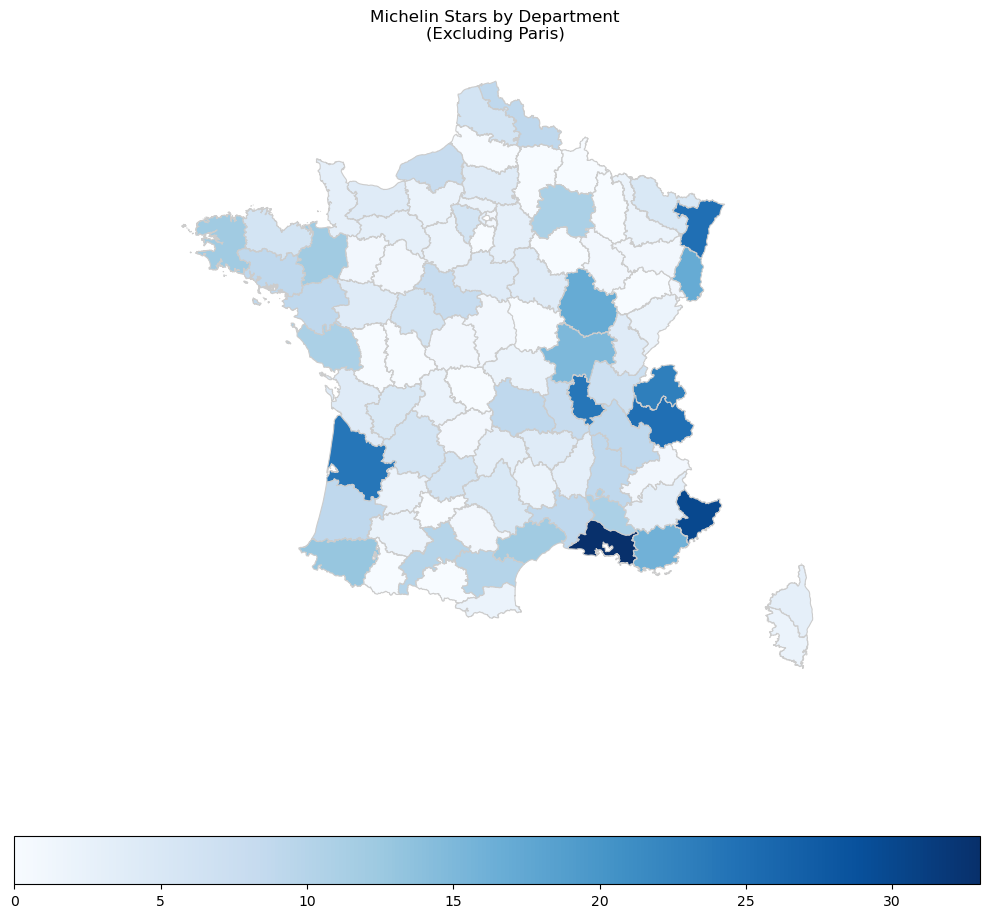

In [13]:
plot_choropleth(no_paris, 'total_stars', "Michelin Stars by Department\n(Excluding Paris)")

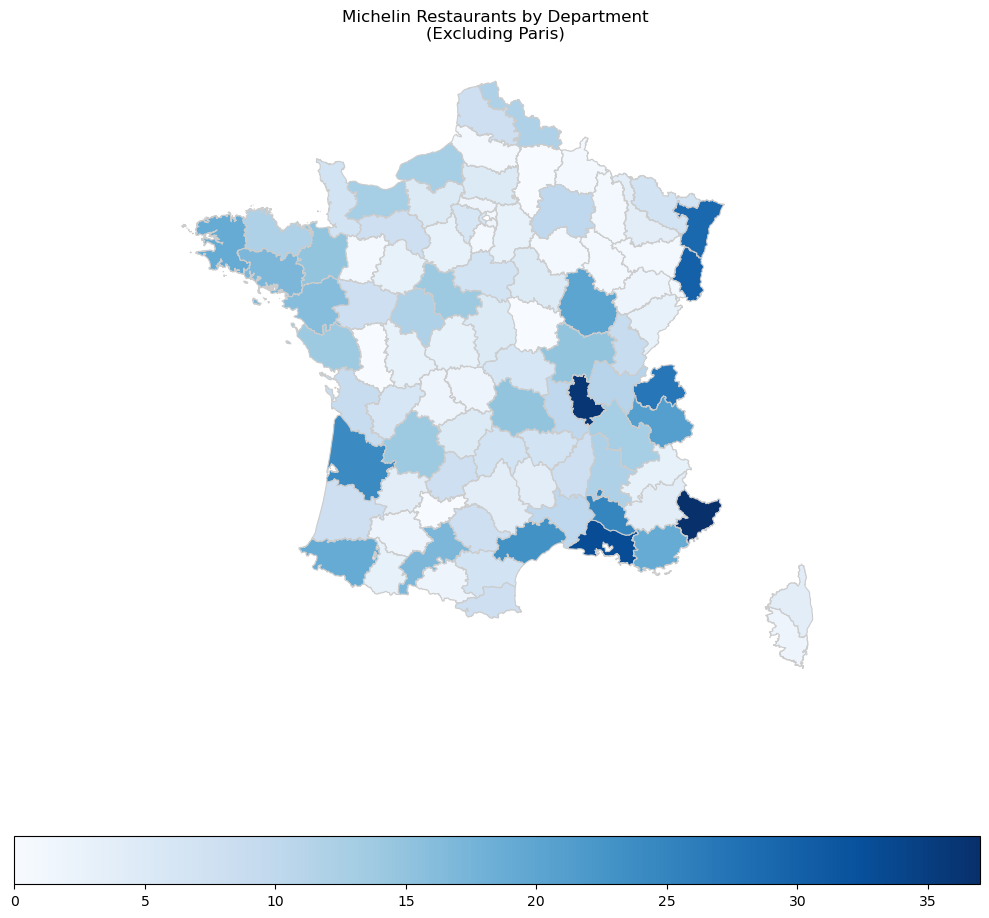

In [14]:
plot_choropleth(no_paris, 'total_restaurants', "Michelin Restaurants by Department\n(Excluding Paris)")

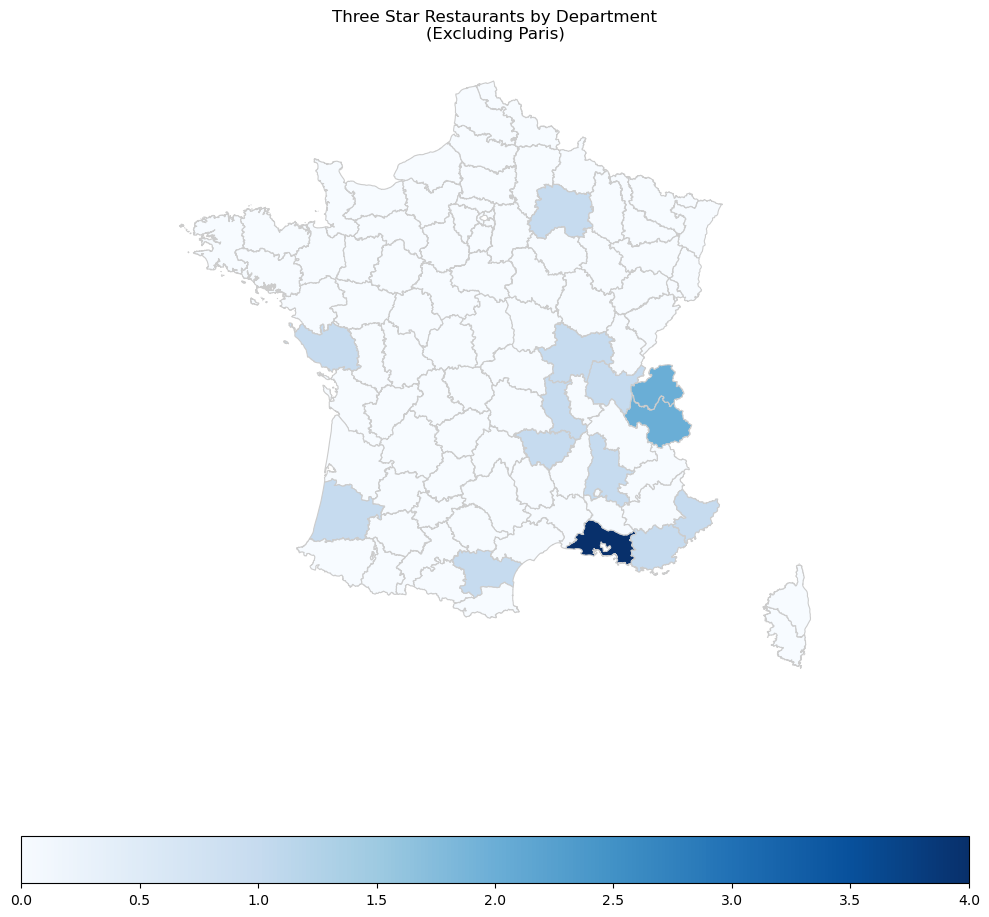

In [15]:
plot_choropleth(no_paris, '3_star', "Three Star Restaurants by Department\n(Excluding Paris)")

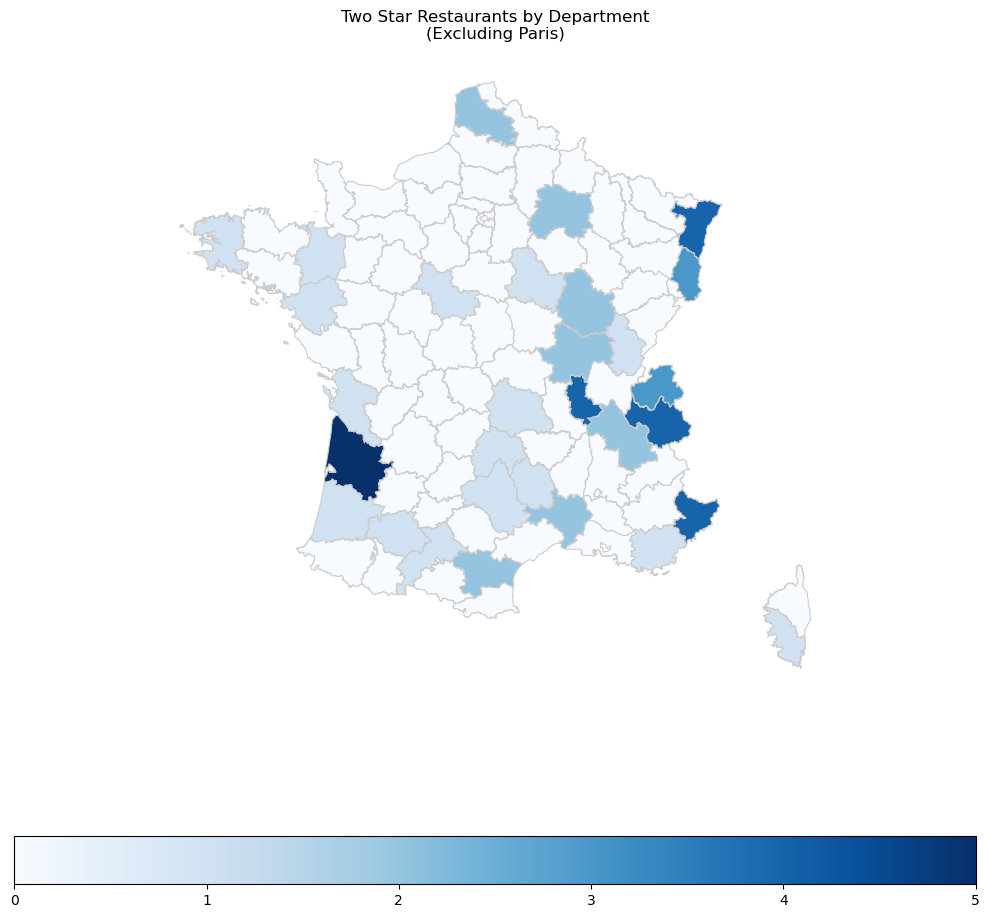

In [16]:
plot_choropleth(no_paris, '2_star', "Two Star Restaurants by Department\n(Excluding Paris)")

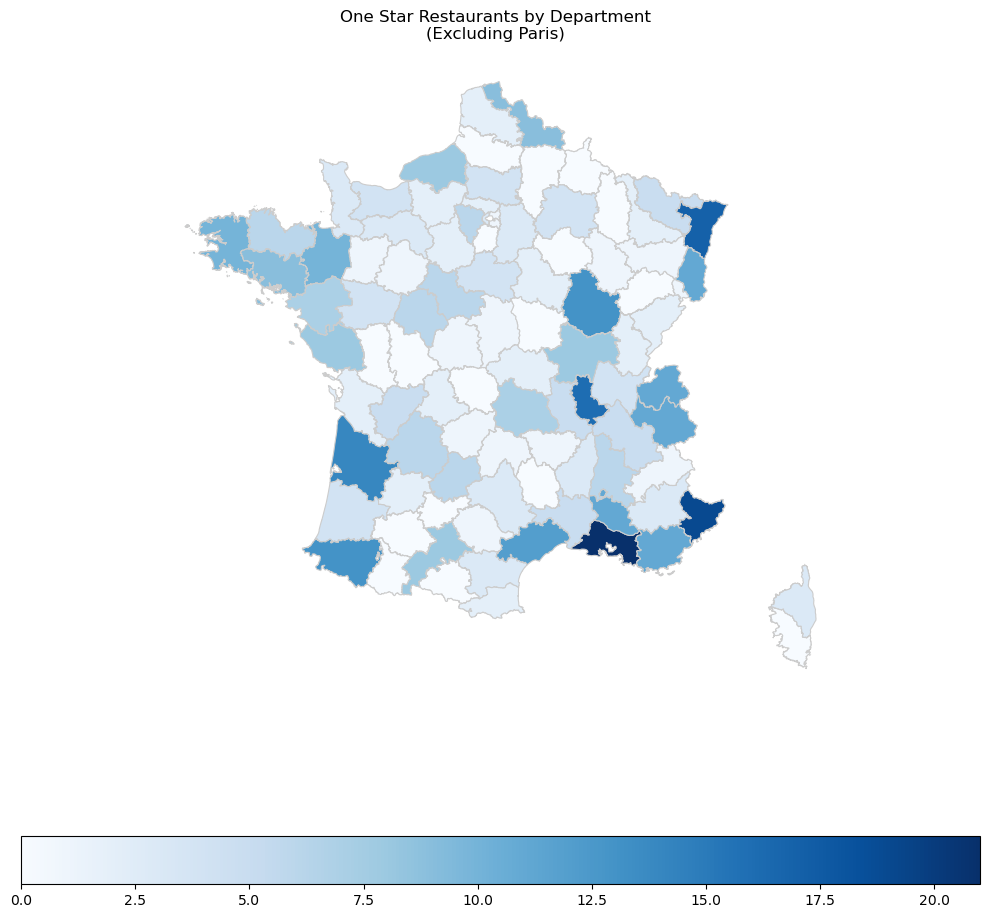

In [17]:
plot_choropleth(no_paris, '1_star', "One Star Restaurants by Department\n(Excluding Paris)")

### Plotting multiple maps on the same figure

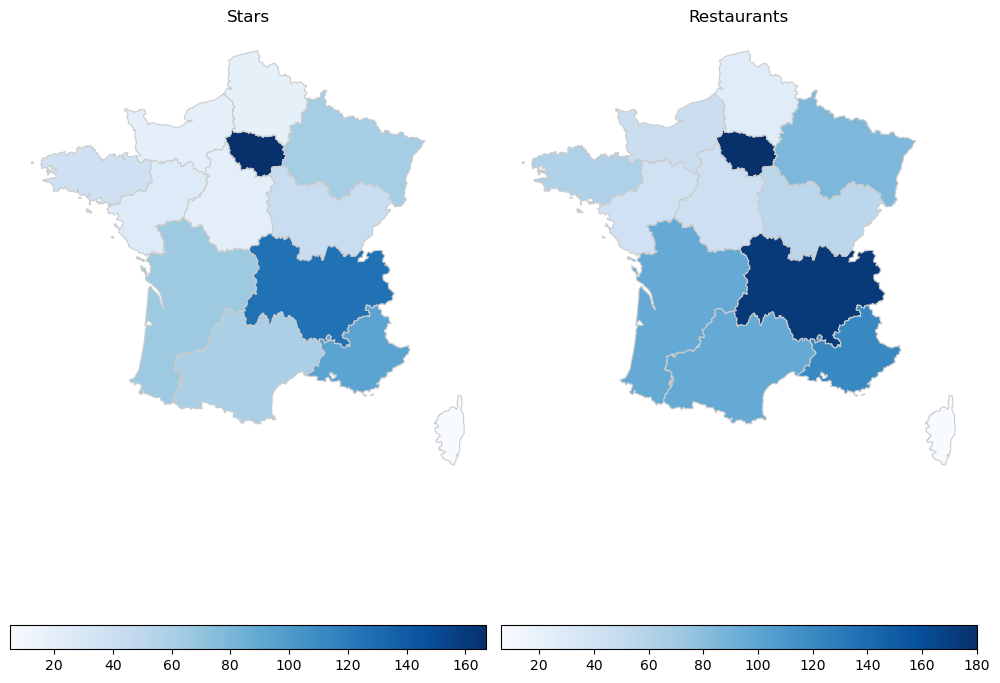

In [18]:
plot_multi_choropleth(regions, ['total_stars', 'total_restaurants'],
                ['Stars', 'Restaurants'])

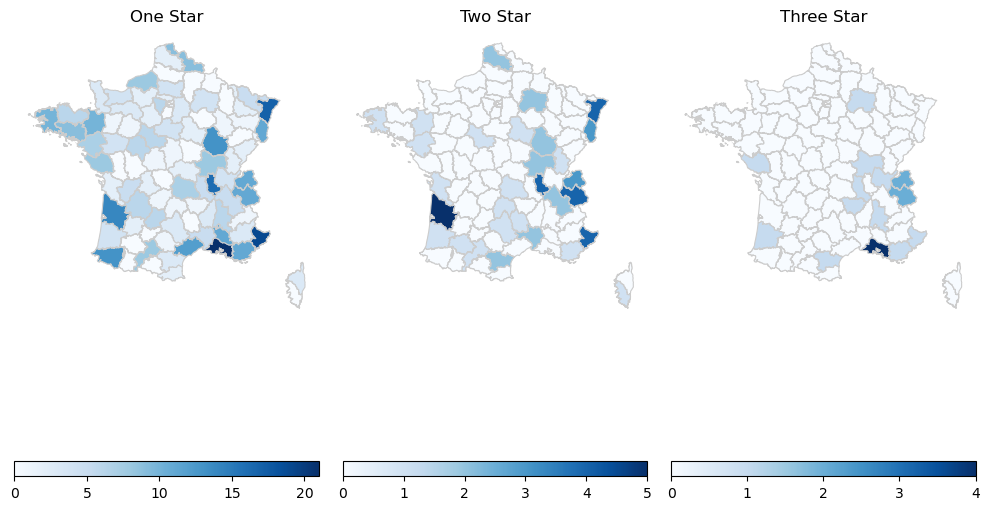

In [19]:
plot_multi_choropleth(no_paris, ['1_star', '2_star', '3_star'],
                ['One Star', 'Two Star', 'Three Star'])

----
&nbsp;
## Filtering by Region

### Provence-Alpes-Côte d'Azur

In [20]:
print(departments['region'].unique().tolist())

['Auvergne-Rhône-Alpes', 'Hauts-de-France', "Provence-Alpes-Côte d'Azur", 'Corsica', 'Grand Est', 'Occitanie', 'Normandy', 'Nouvelle-Aquitaine', 'Centre-Val de Loire', 'Bourgogne-Franche-Comté', 'Brittany', 'Pays de la Loire', 'Île-de-France']


In [30]:
paca = departments[departments['region'] == "Provence-Alpes-Côte d'Azur"]
cote_d_azur = departments[departments['department'].isin(['Alpes-Maritimes', 'Var'])]

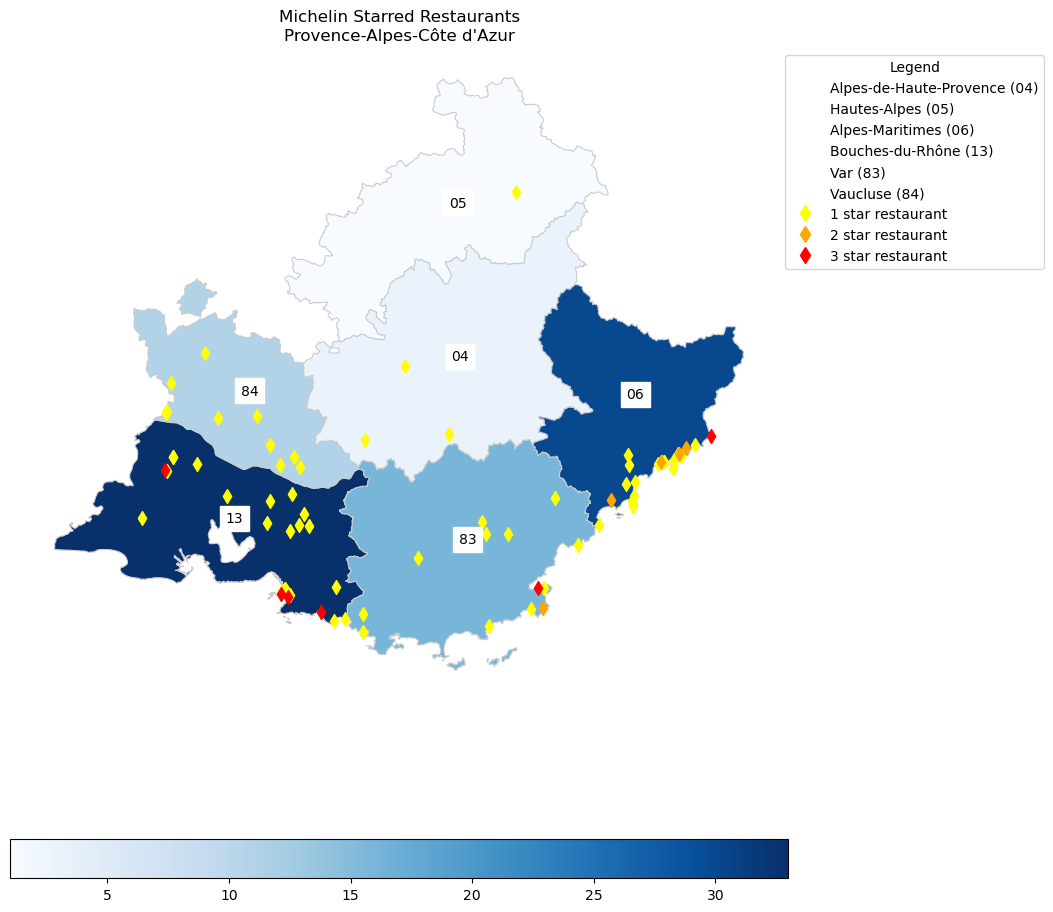

In [31]:
plot_choropleth(paca, 'total_stars', "Michelin Starred Restaurants", regional=True, restaurants=True)

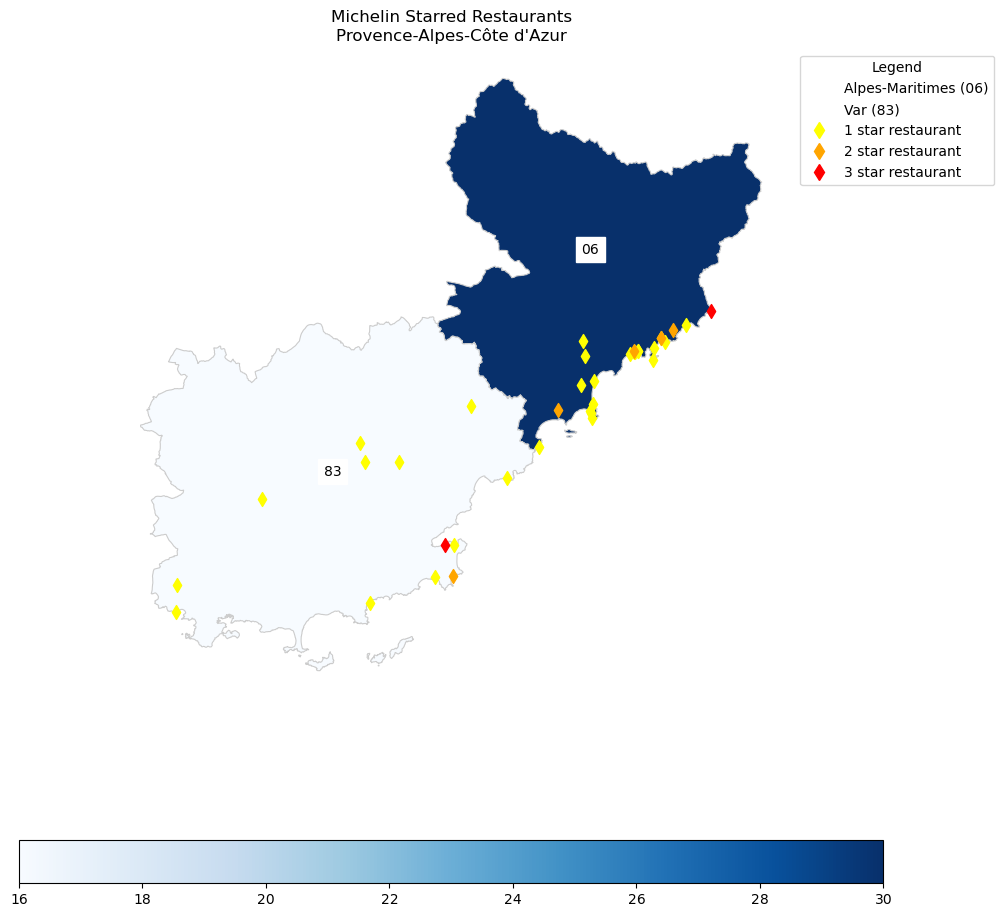

In [32]:
plot_choropleth(cote_d_azur, 'total_stars', "Michelin Starred Restaurants", regional=True, restaurants=True)

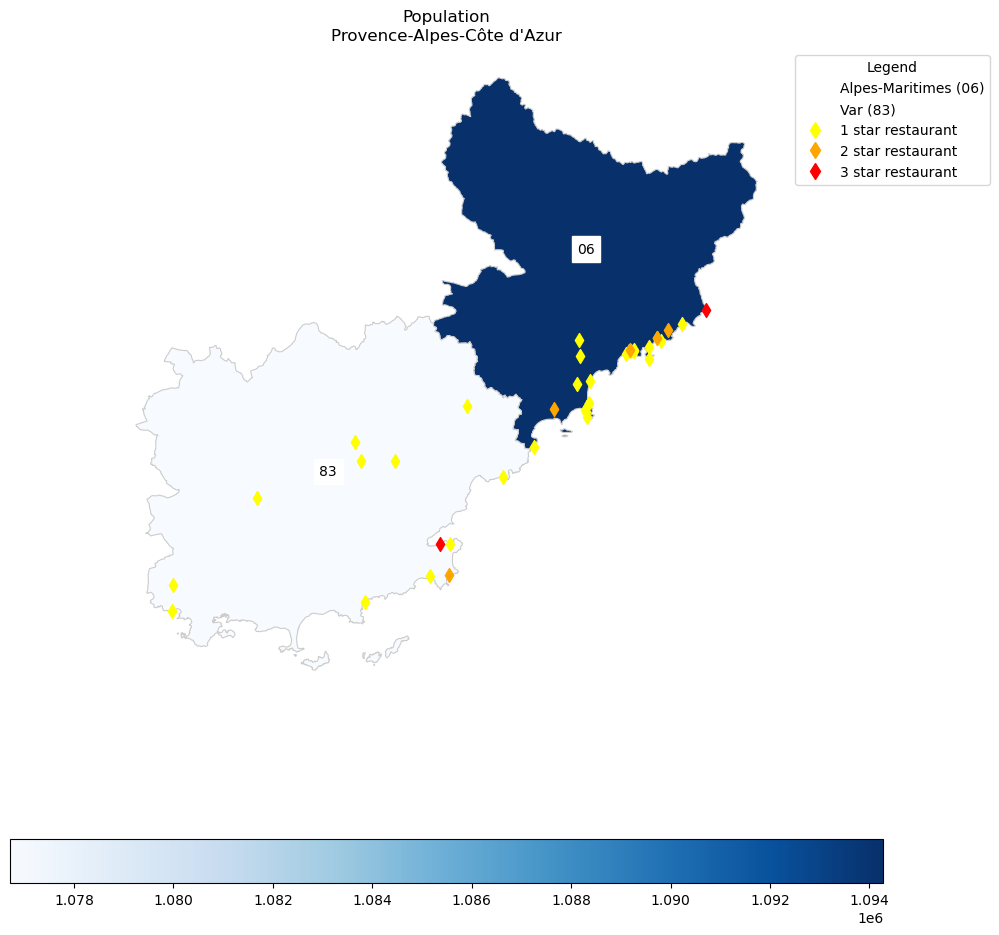

In [33]:
plot_choropleth(cote_d_azur, 'population', "Population", regional=True, restaurants=True)

----
### Occitanie

In [25]:
occitanie = departments[departments['region'] == "Occitanie"]

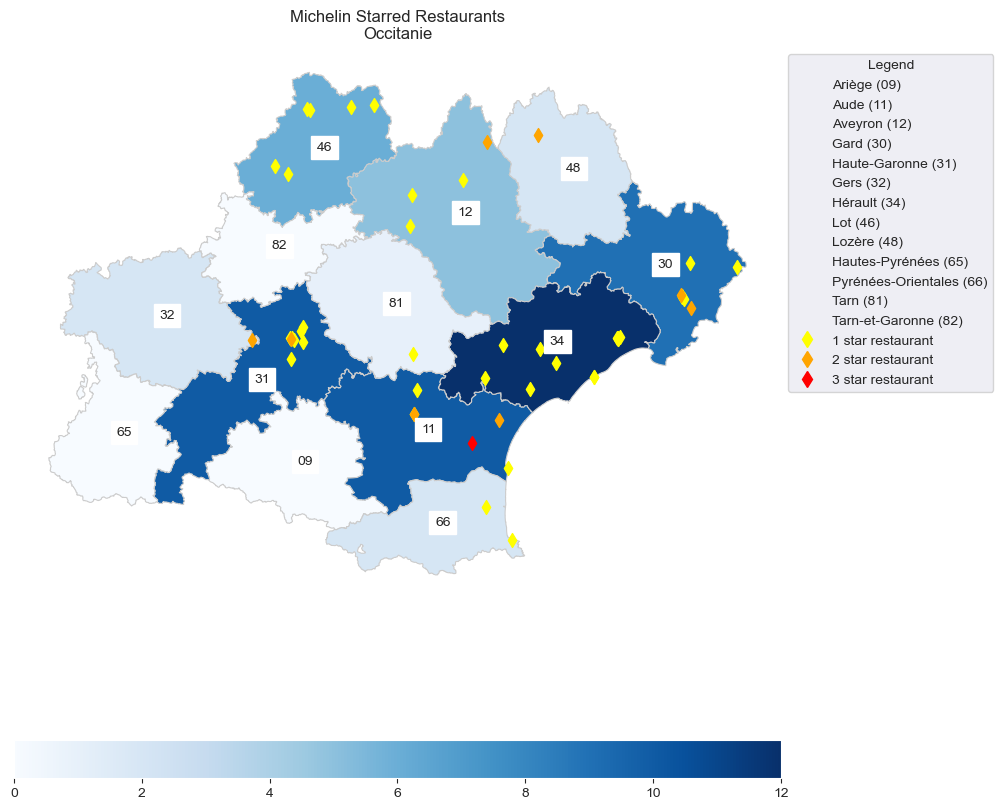

In [26]:
plot_choropleth(occitanie, 'total_stars', "Michelin Starred Restaurants", regional=True, restaurants=True)

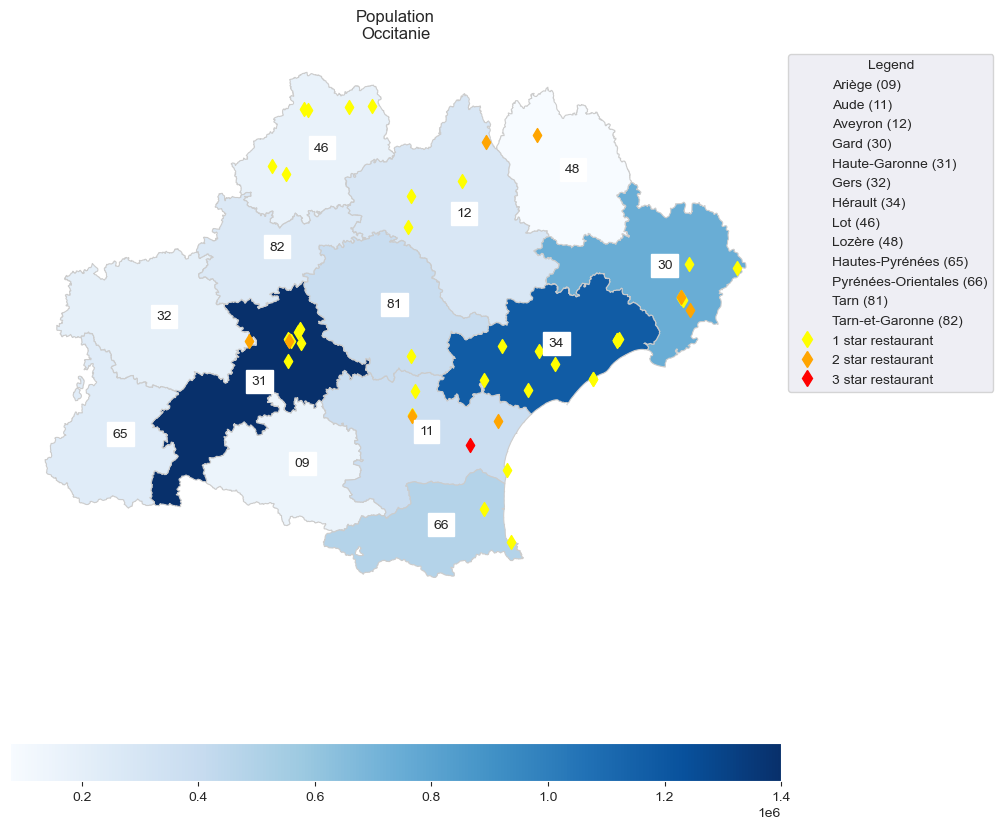

In [27]:
plot_choropleth(occitanie, 'population', "Population", regional=True, restaurants=True)